# Sparse Hebbian Learning: toward a quantitative measure of the quality of filters

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import pandas as pd

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [3]:
DEBUG_DOWNSCALE, verbose = 10, 0
DEBUG_DOWNSCALE, verbose = 1, 0
DEBUG_DOWNSCALE, verbose = 10, 10
DEBUG_DOWNSCALE, verbose = 1, 10

tag = 'independance'
tag = 'mutual_information'

eta_homeo = 0.1

homeo_methods = ['HEH', 'None']
nb_quant = 128
nb_quant = 256
C = 5.
alpha_homeo = 0.0

homeo_methods = ['HAP', 'None']
alpha_homeo = 1.

n_iter = 2**13 + 1

record_num_batches = 2**12
N_show = 120
max_patches = 10
seed = 42
np.random.seed(seed)

opts = dict(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, n_iter=n_iter, 
            eta_homeo=eta_homeo, alpha_homeo=alpha_homeo, 
            C=C, nb_quant=nb_quant, P_cum=None, verbose=verbose)

from shl_scripts.shl_experiments import SHL
shl = SHL(**opts)
data = shl.get_data(matname=tag)

Extracting data..No cache found data_cache/mutual_information_data: Extracting data... Extracting data..bird08.png, yellowleaves39.png, rocky10.png, bittern62.png, flowerhill29.png, clouds43.png, goldwater67.png, calcoast09.png, yose05.png, woods54.png, koala52.png, bora04.png, flowers37.png, yose07.png, cattails70.png, hibiscus30.png, cucorn50.png, geyser27.png, reflection63.png, craterlake12.png, Data is of shape : (81920, 144) - done in 10.68s.
Data is of shape : (81920, 144) - done in 11.28s.


In [4]:
!ls -l {shl.data_cache}/{tag}*
!rm -fr {shl.data_cache}/{tag}*lock*

-rw-r--r--  1 lolo  staff  94371968 Feb 21 17:07 data_cache/mutual_information_data.npy


In [5]:
print('number of patches, size of patches = ', data.shape)
print('average of patches = ', data.mean(), ' +/- ', data.mean(axis=1).std())
SE = np.sqrt(np.mean(data**2, axis=1))
print('average energy of data = ', SE.mean(), '+/-', SE.std())

number of patches, size of patches =  (81920, 144)
average of patches =  -1.5845357615905582e-05  +/-  0.008061093893545403
average energy of data =  0.05804771717773831 +/- 0.06573472852238083


In [6]:
stick = np.arange(shl.n_dictionary)*nb_quant

indx = np.random.permutation(data.shape[0])[:record_num_batches]
P_cum_zeroeffect = np.linspace(0, 1, nb_quant, endpoint=True)[np.newaxis, :] * np.ones((shl.n_dictionary, 1))


## learning

The actual learning is done in a second object (here ``dico``) from which we can access another set of properties and functions  (see the [shl_learn.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_learn.py) script):

No cache found data_cache/mutual_information_HAP_dico.pkl: Learning the dictionary with algo = mp 
 Training on 81920 patches... Learning code... Iteration   1 /   8193 (elapsed time:   1s,   0mn   1s)
Iteration  129 /   8193 (elapsed time:  75s,   1mn  15s)
Iteration  257 /   8193 (elapsed time:  148s,   2mn  28s)
Iteration  385 /   8193 (elapsed time:  221s,   3mn  41s)
Iteration  513 /   8193 (elapsed time:  295s,   4mn  55s)
Iteration  641 /   8193 (elapsed time:  368s,   6mn   8s)
Iteration  769 /   8193 (elapsed time:  441s,   7mn  21s)
Iteration  897 /   8193 (elapsed time:  515s,   8mn  35s)
Iteration  1025 /   8193 (elapsed time:  589s,   9mn  49s)
Iteration  1153 /   8193 (elapsed time:  663s,  11mn   3s)
Iteration  1281 /   8193 (elapsed time:  736s,  12mn  16s)
Iteration  1409 /   8193 (elapsed time:  811s,  13mn  31s)
Iteration  1537 /   8193 (elapsed time:  885s,  14mn  45s)
Iteration  1665 /   8193 (elapsed time:  958s,  15mn  58s)
Iteration  1793 /   8193 (elapsed time:

Iteration  8193 /   8193 (elapsed time:  4612s,  76mn  52s)
done (total time:  4613s,  76.9mn)
done in 4613.03s.
size of dictionary = (number of filters, size of imagelets) =  (529, 144)
average of filters =  0.00017427595886007865 +/- 0.008225463233033633
average energy of filters =  1.0 +/- 8.205996268968548e-17


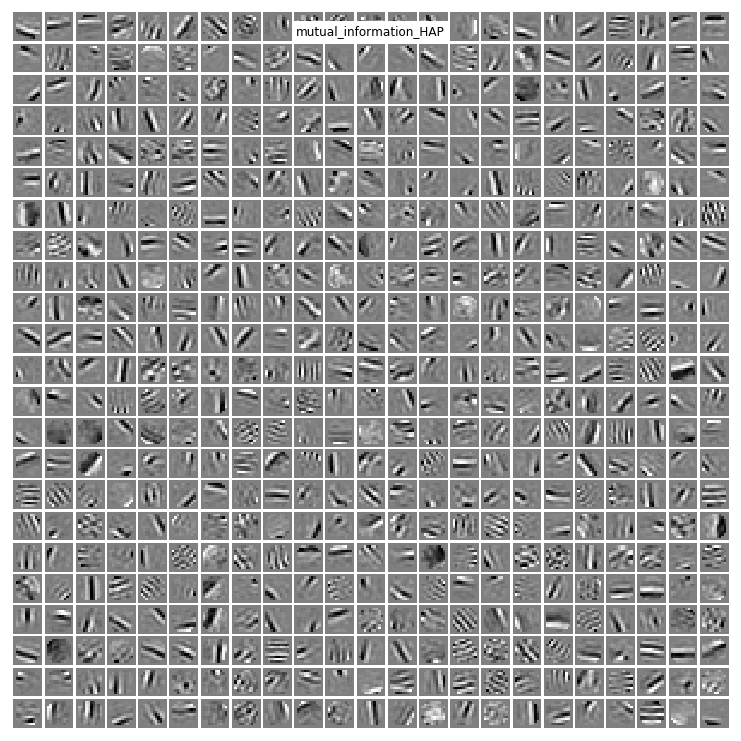

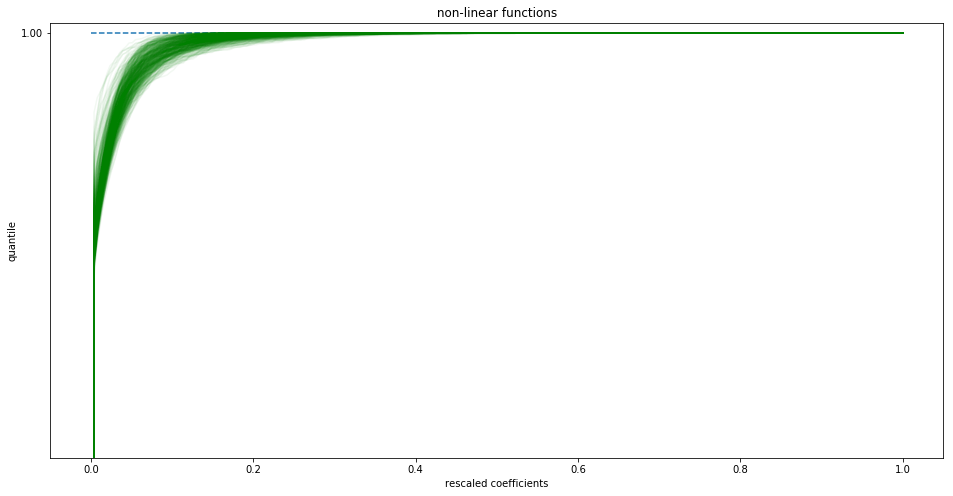

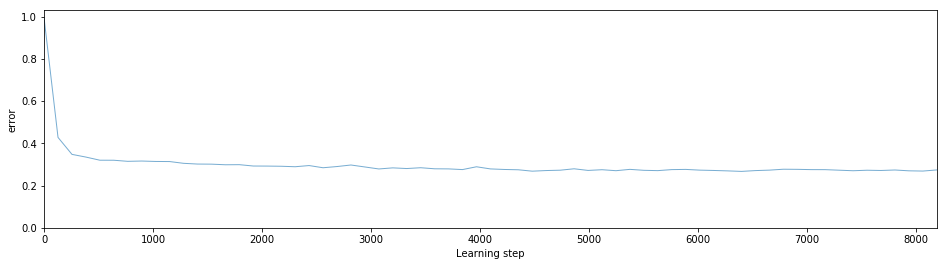

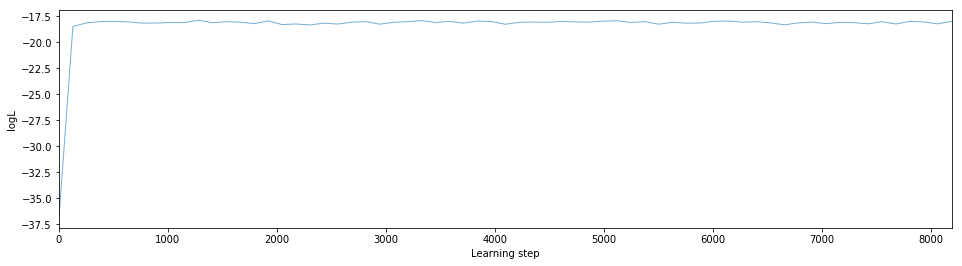

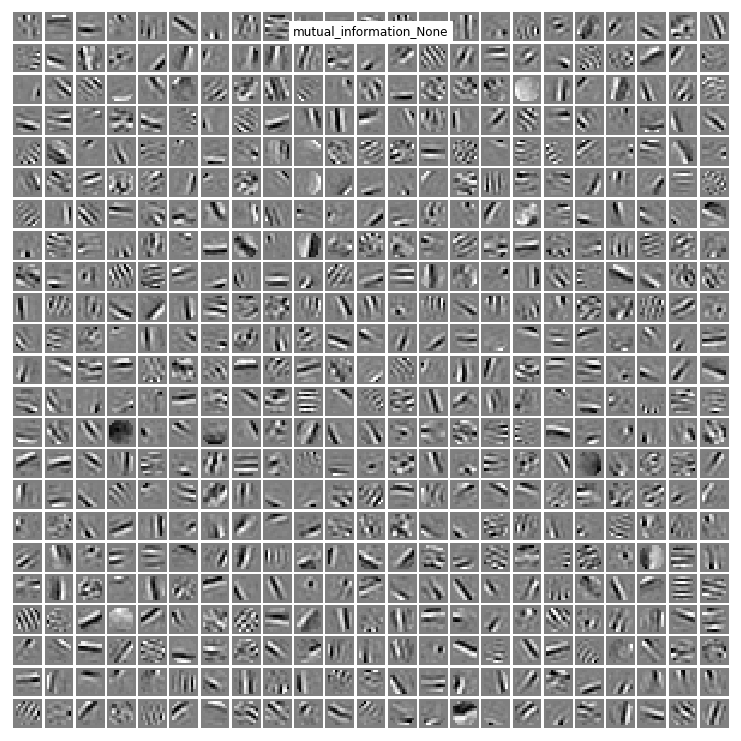

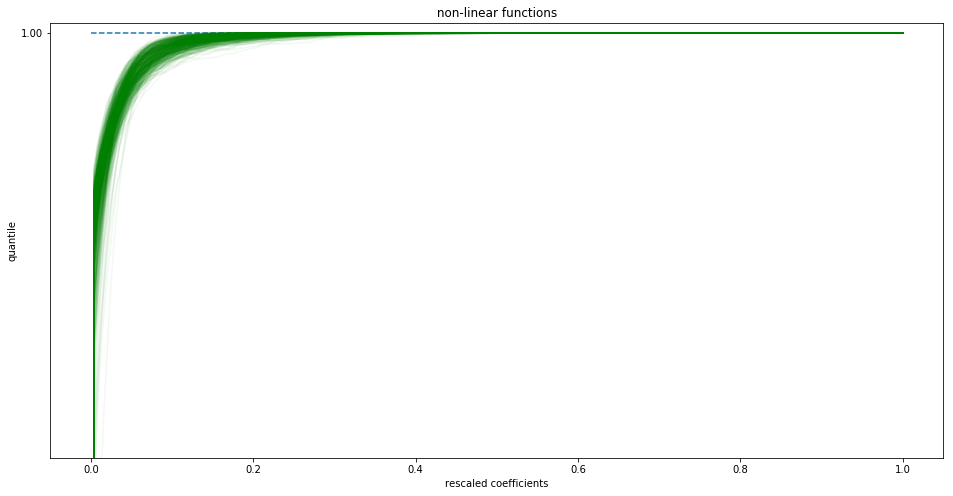

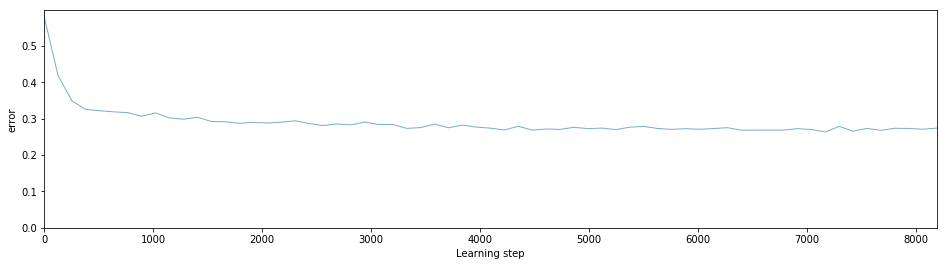

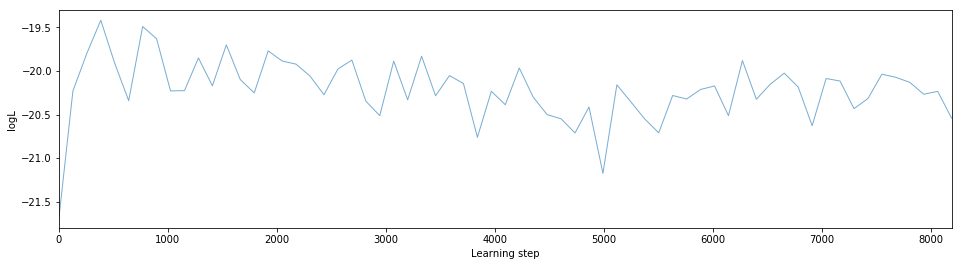

In [7]:
list_figures = ['show_dico', 'time_plot_error', 'time_plot_logL', 'show_Pcum']

dico = {}
for homeo_method in homeo_methods:
    shl = SHL(homeo_method=homeo_method, **opts)
    dico[homeo_method] = shl.learn_dico(data=data, list_figures=list_figures, matname=tag + '_' + homeo_method)

    print('size of dictionary = (number of filters, size of imagelets) = ', dico[homeo_method].dictionary.shape)
    print('average of filters = ',  dico[homeo_method].dictionary.mean(axis=1).mean(), 
          '+/-',  dico[homeo_method].dictionary.mean(axis=1).std())
    SE = np.sqrt(np.sum(dico[homeo_method].dictionary**2, axis=1))
    print('average energy of filters = ', SE.mean(), '+/-', SE.std())

## theory



In [8]:
from scipy.stats import binom
# define the mean
rho = shl.l0_sparseness / shl.n_dictionary

# draw binomial samples
sparse_code_binary = np.random.rand(record_num_batches, shl.n_dictionary) > 1 - rho

In [9]:
print('Sum of non-zero coefficients', sparse_code_binary.sum(), '~=', shl.l0_sparseness*record_num_batches)
print('average non-zeros', np.count_nonzero(sparse_code_binary, axis=0).mean(), '~=', rho*record_num_batches)
print('activation vector', np.count_nonzero(sparse_code_binary, axis=0))

Sum of non-zero coefficients 61459 ~= 61440
average non-zeros 116.17958412098298 ~= 116.14366729678639
activation vector [116 123 115 116 130 107 119  95 109 116 137 107 130 111 119  97 106 110
 127 104 125 113 100 113  97 124 101 129 116 116 104 118 111 118 121 105
 109 115 124 118 116 115 140 116 110 120 142 118 127 127 111 113 121  99
 121  95 128 106 101 105 118 133 103 113 118 111 118 115 110 112 119 101
 116 120 113 127 101 100 123 123 135 119 109 112 107 129 106 126 117  99
 124  99 110 124 115  97 112 107 108 113 112 113 111 101 124 112 117 112
 142 100 108 110 116 130 107 121 118 117 110 115 120 133 117 110 115  99
 104 108 133 107 104 146 122 117 117 119 112 110 123 109 121 126 103 122
 102 125 125 110 117 138 116 114 111 115 122 127 120 142 121 117  94 123
 127 111 105 126 109 120 126 125 118  94 128 129 108 131 129 114 118 114
 104 114  98 125 120 134  98 103 112 117 114 130 115 109 124 114 105 107
 135 130 117 116 108 124 125 121 123 110 109 135 112 122 116 115  98 107
  9

Shape of co-occurrences (4096, 529, 529)
activation vector [[116   2   4 ...   3   5   1]
 [  2 123   3 ...   5   2   5]
 [  4   3 115 ...   2   9   3]
 ...
 [  3   5   2 ... 119  10   9]
 [  5   2   9 ...  10 116   2]
 [  1   5   3 ...   9   2 123]]
marginal activation vector [3.5066 3.8015 3.3932 3.4216 3.9074 3.2363 3.5085 2.7391 3.4669 3.414
 3.9962 3.2344 4.0189 3.3686 3.569  3.0605 3.0851 3.3043 4.0416 3.3403
 3.6597 3.4423 2.983  3.3043 2.9565 3.6692 2.9943 3.9509 3.5766 3.5709
 3.1626 3.5671 3.3289 3.5406 3.5803 3.0945 3.3119 3.5312 3.7297 3.5331
 3.5766 3.5822 4.3611 3.4688 3.2552 3.5747 4.2287 3.6427 3.8431 3.8034
 3.2571 3.4953 3.7996 2.9471 3.6276 2.8299 3.8318 3.2098 3.0491 3.2665
 3.5331 4.1664 2.9622 3.4008 3.5879 3.3119 3.5217 3.448  3.4405 3.4234
 3.4594 2.9887 3.6767 3.6578 3.3743 3.9244 3.0605 3.0095 3.7051 3.8072
 4.2004 3.482  3.276  3.3157 3.2476 3.7599 3.2155 3.8185 3.5369 3.0605
 3.9225 3.0567 3.2287 3.724  3.5577 2.9641 3.4234 3.2382 3.3006 3.4556
 3.5274 3.259

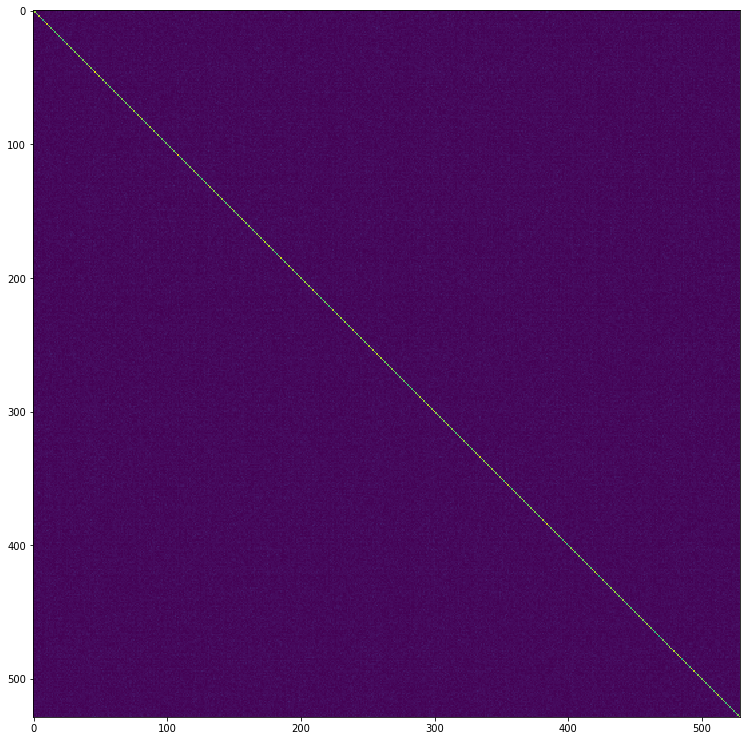

In [10]:
b_ij = (sparse_code_binary[:, np.newaxis, :]>0) * (sparse_code_binary[:, :, np.newaxis]>0)
print('Shape of co-occurrences', b_ij.shape)
print('activation vector', np.count_nonzero(b_ij, axis=0))
fig, ax= plt.subplots(figsize=(13, 13))
ax.imshow(np.count_nonzero(b_ij, axis=0));
print('marginal activation vector', np.count_nonzero(b_ij, axis=0).mean(axis=-1))

Min-Max -2.019130374645612e-06 0.00048547754167835235


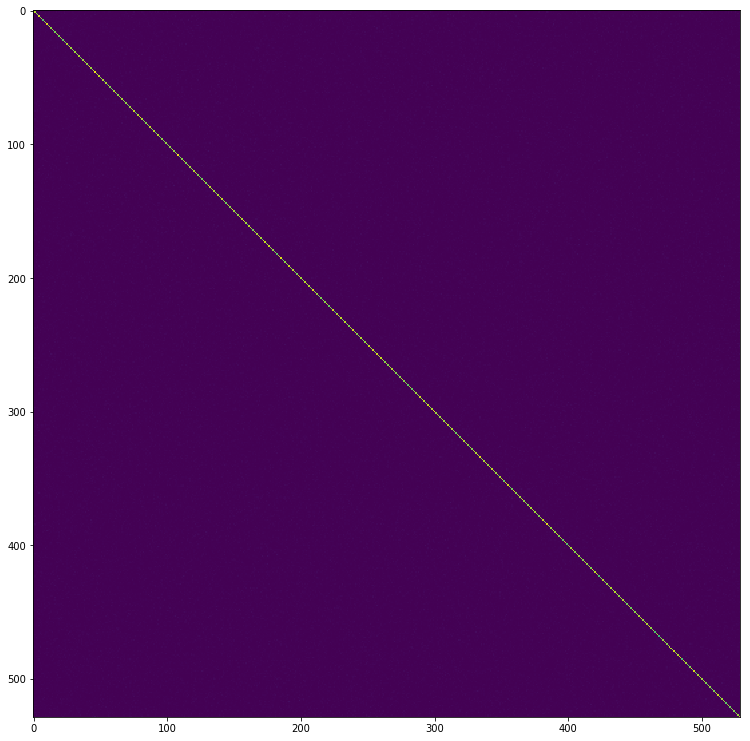

In [11]:
b_ij = (sparse_code_binary[:, np.newaxis, :]>0) * (sparse_code_binary[:, :, np.newaxis]>0)
P_ij = 1.*np.count_nonzero(b_ij, axis=0)
P_ij /= P_ij.sum()
P_i = 1.*np.count_nonzero(sparse_code_binary, axis=0)
P_i /= P_i.sum()
fig, ax= plt.subplots(figsize=(13, 13))
MI_ = - (P_ij * np.log( P_i[:, np.newaxis]*P_i[np.newaxis, :] / P_ij  ))
MI_[P_ij==0] = 0
MI_[(P_i[:, np.newaxis]*P_i[np.newaxis, :])==0] = 0
print('Min-Max', MI_.min(), MI_.max())
ax.imshow(MI_);

In [12]:
def get_MI(sparse_code):
    b_ij = (sparse_code[:, np.newaxis, :]>0) * (sparse_code[:, :, np.newaxis]>0)
    P_ij = 1.*np.count_nonzero(b_ij, axis=0)
    P_ij /= P_ij.sum()
    P_i = 1.*np.count_nonzero(sparse_code_binary, axis=0)
    P_i /= P_i.sum()
    MI_ = - P_ij * np.log( P_i[:, np.newaxis]*P_i[np.newaxis, :] / P_ij  )
    MI_[P_ij==0] = 0
    MI_[(P_i[:, np.newaxis]*P_i[np.newaxis, :])==0] = 0
    return MI_.sum()
    

In [13]:
for _ in range(10):
    sparse_code_binary = np.random.rand(record_num_batches, shl.n_dictionary) > 1 - rho
    MI = get_MI(sparse_code_binary)
    print ('Mutual information for random sample=', MI)


Mutual information for random sample= 0.30460847388695883
Mutual information for random sample= 0.3052953323446256
Mutual information for random sample= 0.30506732380158513
Mutual information for random sample= 0.3090419908226029
Mutual information for random sample= 0.3066501873215011
Mutual information for random sample= 0.30711055767730394
Mutual information for random sample= 0.3052227903440829
Mutual information for random sample= 0.3067199741729895
Mutual information for random sample= 0.3060277006925692
Mutual information for random sample= 0.31188704263193545


## coding

The learning itself is done via a gradient descent but is highly dependent on the coding / decoding algorithm. This belongs to a another function (in the [shl_encode.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_encode.py) script)

In [14]:
from shl_scripts.shl_tools import show_data
def print_stats(data, dictionary, sparse_code):
    print(42*'🐒')

    print('number of codes, size of codewords = ', sparse_code.shape)
    print('average of codewords = ', sparse_code.mean())
    print('average std of codewords = ', sparse_code.std())
    print('l0-sparseness of codewords = ', (sparse_code>0).mean(), ' ~= l0/M =', shl.l0_sparseness/shl.n_dictionary)
    print('std of the average of individual patches = ', sparse_code.mean(axis=0).std())


    plt.matshow(sparse_code[:N_show, :])
    plt.show()
    fig, axs = show_data(data[:max_patches, :])
    plt.show()

    patches = sparse_code @ dictionary
    error = data - patches
    
    print('number of codes, size of reconstructed images = ', patches.shape)

    fig, axs = show_data(patches[:max_patches, :])
    plt.show()
    fig, axs = show_data(error[:max_patches, :], cmax=np.max(np.abs(patches[:max_patches, :])))
    plt.show()
    print('average of data patches = ', data.mean(), '+/-', data.mean(axis=1).std())
    print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
    SD = np.sqrt(np.mean(data**2, axis=1))

    print('median energy of data = ', np.median(SD))
    print('average energy of data = ', SD.mean(), '+/-', SD.std())
    
    SE = np.sqrt(np.mean(error**2, axis=1))

    print('average energy of residual = ', SE.mean(), '+/-', SE.std())
    print('median energy of residual = ', np.median(SE))
    print('average gain of coding = ', (SD/SE).mean(), '+/-', (SD/SE).std())
    
    return SD, SE

In [15]:
homeo_methods

['HAP', 'None']

🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (4096, 529)
average of codewords =  0.003791968364979236
average std of codewords =  0.04148245792058023
l0-sparseness of codewords =  0.025829985822306237  ~= l0/M = 0.02835538752362949
std of the average of individual patches =  0.004631844332103613


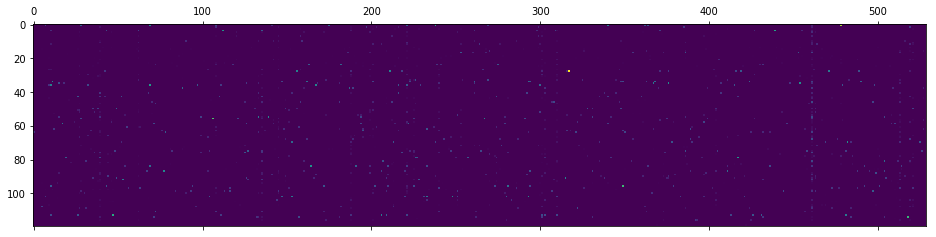

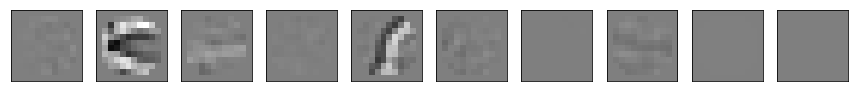

number of codes, size of reconstructed images =  (4096, 144)


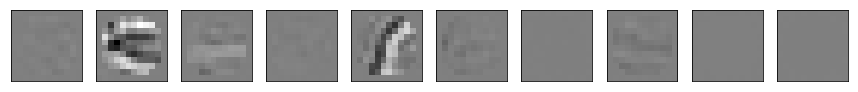

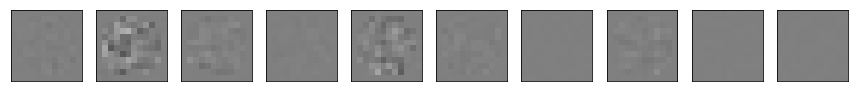

average of data patches =  0.00017425179566852054 +/- 0.008048186258251454
average of residual patches =  0.0005578376111439061 +/- 0.0017738036307508938
median energy of data =  0.03528617489653011
average energy of data =  0.05671944996196754 +/- 0.06428685111716277
average energy of residual =  0.023325056780614056 +/- 0.02376228676271324
median energy of residual =  0.018390865146673027
average gain of coding =  2.9232472125524605 +/- 1.4370195293116779
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (4096, 529)
average of codewords =  0.004001426285350088
average std of codewords =  0.04185359969283202
l0-sparseness of codewords =  0.028024482366493384  ~= l0/M = 0.02835538752362949
std of the average of individual patches =  0.003205011985514539


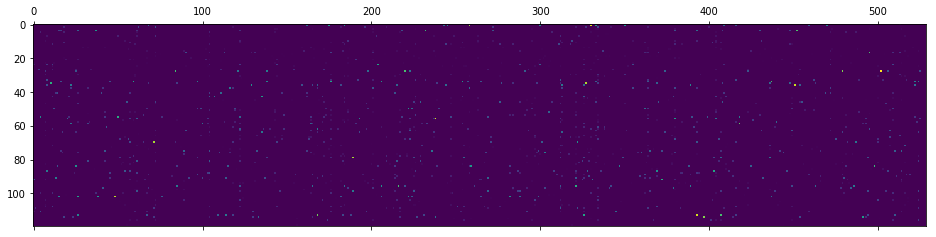

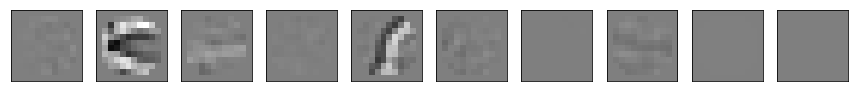

number of codes, size of reconstructed images =  (4096, 144)


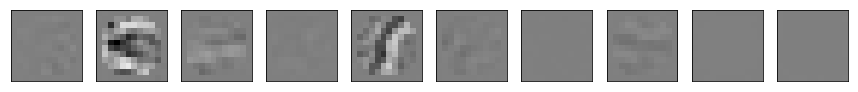

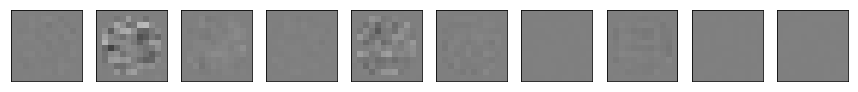

average of data patches =  0.00017425179566852054 +/- 0.008048186258251454
average of residual patches =  -0.000610732583652496 +/- 0.003612758207130869
median energy of data =  0.03528617489653011
average energy of data =  0.05671944996196754 +/- 0.06428685111716277
average energy of residual =  0.020663004320522413 +/- 0.021712266943872575
median energy of residual =  0.015135807287354752
average gain of coding =  3.431639689057544 +/- 2.098551563371972


In [16]:
from shl_scripts.shl_encode import sparse_encode
sparse_code = {}
for homeo_method in homeo_methods:
    if dico[homeo_method].P_cum is None: 
        gain = np.ones(shl.n_dictionary)
    else:
        gain = None
    sparse_code[homeo_method] = sparse_encode(data[indx, :], dico[homeo_method].dictionary, 
                                 P_cum=dico[homeo_method].P_cum, l0_sparseness = shl.l0_sparseness, C=C, gain=gain)
    SD, SE = print_stats(data[indx, :], dico[homeo_method].dictionary, sparse_code[homeo_method])

## measuring the distance to independance 

In [17]:
#fig, ax= plt.subplots(figsize=(13, 5))
for homeo_method in homeo_methods:
    MI = get_MI(sparse_code[homeo_method])
    print ('Mutual information for homeo_method=', homeo_method, 'is', MI)


Mutual information for homeo_method= HAP is 1.560784712728049
Mutual information for homeo_method= None is 1.1615967024372045


## Version used

In [18]:
%load_ext version_information
%version_information numpy, shl_scripts, pandas

Software versions
Python 3.6.4 64bit [GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]
IPython 6.2.1
OS Darwin 17.4.0 x86_64 i386 64bit
numpy 1.14.1
shl_scripts 20171221
pandas 0.22.0
Wed Feb 21 19:42:18 2018 CET